In [81]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import plotly.figure_factory as ff
import plotly.express as px
import datetime
import networkx as nx
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Classifying Tweet Authorship by Candidate

In [2]:
# Load in the CSV file created earlier from the tweets that were scraped from various sources
df = pd.read_csv('candidatetweets_dataframe.csv')

In [4]:
# The dataset is slightly unbalanced because Trump tweets more often in the given time period
df['name'].value_counts()

Donald J. Trump    5518
Joe Biden          3000
Name: name, dtype: int64

In [257]:
# Using tweet tokenizer to help with tokenizing the tweets, makes sense.
tt = TweetTokenizer()
# Porter stemmer for stemming tokens, but it wasn't used in the end
ps = PorterStemmer()
# Stopwords were removed from the document to only get meaningful features
custom_stopwords = ["https", "co", "amp", '’']
stopword_list = set(stopwords.words('english')).union(custom_stopwords)

In [258]:
# For preprocessing a given document
def prep_doc(doc, stem=True):
  # Use tweet tokenizer on lowercase document
  tokens = tt.tokenize(doc.lower())
  # Use regular expression to find tokens consisting of links and filter them out
  regexp = re.compile('http.*')
  filtered = list(filter(lambda x: not re.match(regexp, x), tokens))
  # Optionally stem the tokens with the Porter Stemmer (not used in the final model as it did not improve the results significantly)
  if stem:
    filtered = [ps.stem(token) for token in filtered]
  # Return the tokenized and filtered document, removing stopwords
  return [token for token in filtered if token not in stopword_list]

In [259]:
# For transforming all docs, not including the counts
def transform_data(data, threshold, stem=True):
  # Counts the number of occurrences of each token in each document
  cv = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
  # Applies preprocessing function to each document, with optional stemming
  docs = [prep_doc(doc, stem) for doc in data]
  cv.fit(docs)
  # Make a dataframe out of the document-term matrix with the words as the column names
  dtm = pd.DataFrame(cv.transform(docs).toarray(), columns=cv.get_feature_names())
  # Get the complete list of features (word tokens)
  full_features = np.array(cv.get_feature_names())
  # Find where the occurrences of a word are below the chosen threshold
  feature_inds = np.where(dtm.sum(axis=1) > threshold)
  # Filter features
  features = full_features[feature_inds]
  to_remove = [f for f in dtm.columns if f not in features]
  dtm = dtm.drop(to_remove, axis=1)
  return dtm, features

In [260]:
# Apply the data transformation to the text to get the document-term matrix along with a list of features
dtm, features = transform_data(data=df['text'], threshold=20, stem=False)
# Takes us from about 14000 features to 4510

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [261]:
# Get the X and y variables for the dataset to prepare for model training
X = dtm.to_numpy()
# y = 0 arbitrarily chosen for Trump and y = 1 for Biden
y = np.array(df['name'] == 'Joe Biden')

In [262]:
# Multinomial Naive Bayes classifier was chosen, after trying Gaussian Naive Bayes
# Smoothing hyperparameter tuned over several runs to this value
clf = MultinomialNB(alpha=0.5)
# Checking precision and recall
scoring = ['precision_macro', 'recall_macro']
# Do 5-fold (default) cross-validation of this model on the dataset
scores = cross_validate(clf, X, y, scoring=scoring)
# Show average precision and recall over the 5 models
print(np.mean(scores['test_precision_macro']))
print(np.mean(scores['test_recall_macro']))

0.9073688166750544
0.9028886961777498


In [ ]:
# Fit to full data
clf.fit(X, y)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [ ]:
# Look at top features
trump_coeffs = pd.DataFrame({'feature': features, 'coeff': clf.feature_log_prob_[0]})
biden_coeffs = pd.DataFrame({'feature': features, 'coeff': clf.feature_log_prob_[1]})

In [ ]:
# Look at top 50 features for both candidates
# (Log probability, so very high probability corresponds to negative values closer to zero)
biden_top = biden_coeffs.sort_values('coeff').tail(50)
trump_top = trump_coeffs.sort_values('coeff').tail(50)

In [ ]:
# Get top unique features by taking the symmetric difference of the top 50 for the two candidates
top_unique = list(set(biden_top['feature']).symmetric_difference(set(trump_top['feature'])))

In [ ]:
# Get the key features for each candidate by finding the top ones in the unique list
biden_key_features = biden_top[biden_top.apply(lambda x: x['feature'] in top_unique, axis=1)].head(30)
biden_key_features.reset_index(drop=True, inplace=True)

trump_key_features = trump_top[trump_top.apply(lambda x: x['feature'] in top_unique, axis=1)].head(30)
trump_key_features.reset_index(drop=True, inplace=True)

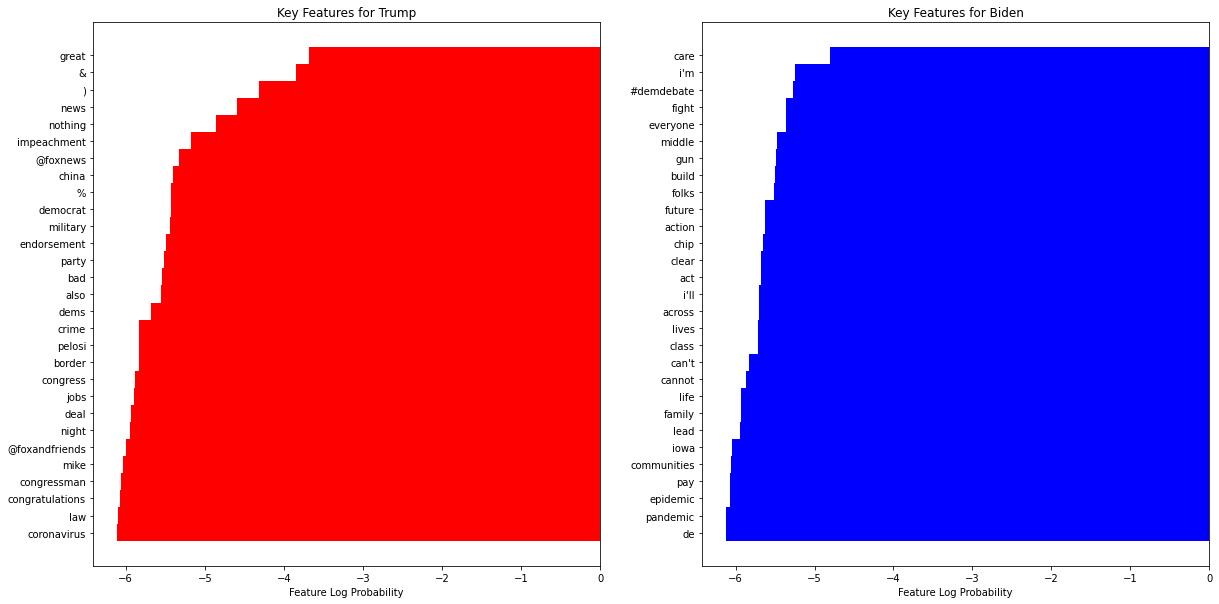

In [ ]:
# Show these top features for each candidate along with their log probabilities
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,10])
axs[0].barh(trump_key_features['feature'], width=trump_key_features['coeff'], height=1, color='red')
axs[0].set_title('Key Features for Trump')
axs[0].set_xlabel('Feature Log Probability')
axs[1].barh(biden_key_features['feature'], width=biden_key_features['coeff'], height=1, color='blue')
axs[1].set_title('Key Features for Biden')
axs[1].set_xlabel('Feature Log Probability')
plt.show()
# Note that these are the words which according to the Naive Bayes model are very good indications for a particular candidate while not being as good an indication for the other candidate.
# So Trump is more likely to say "great" and Biden is more likely to say "care", etc.

# Map of Percent Differences in Poll Averages

In [ ]:
# Load in the poll data from 538
polls = pd.read_csv("https://projects.fivethirtyeight.com/2020-general-data/presidential_poll_averages_2020.csv")
# Check the states shown in the data -- note there are a couple of extra aggregations that will need to be removed
myset = set(polls['state'])
print(sorted(myset))

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'ME-1', 'ME-2', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'NE-1', 'NE-2', 'National', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin']


In [ ]:
# Convert to datetime object so dates display correctly
polls['modeldate'] = pd.to_datetime(polls['modeldate'])
# Order the dates
polls = polls.sort_values('modeldate')
# Remove all the state names corresponding to aggregations
polls = polls[polls.apply(lambda x: x['state'] not in ['National', 'NE-1', 'NE-2', 'ME-1', 'ME-2'], axis=1)]

In [ ]:
# Look at only a recent particular date for the average poll results
state_df = polls.query('modeldate == "8/28/2020"')
# Extract only the rows for the candidate poll averages and not for the convention bouncebacks
state_df = state_df.query('candidate_name == "Donald Trump" or candidate_name == "Joseph R. Biden Jr."')
# Reset the row numbers
state_df.reset_index(drop=True, inplace=True)

In [ ]:
# List of US state abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Function to get a state abbreviation from its name by looking it up in the dictionary
def state_lookup(state):
  return us_state_abbrev[state]

# Apply the lookup function to make a column for the abbreviations, needed for the map
state_df['abbr'] = state_df['state'].apply(state_lookup)

In [ ]:
# Creating a new dataframe containing the state name, abbreviation, and percent difference between candidates for that state
# Get the list of state names and abbreviations, alphabetically sorted
states_full = list(sorted(set(state_df['state'])))
states_abbr = [state_lookup(state) for state in states_full]

# Function to lookup the poll averages for Trump and Biden for a given state and calculate the difference.
# Arbitrarily chooses to do trump - biden, so states favoring Trump will be positive and states favoring Biden will be negative on the scale
def get_pct_diff(state):
  ind1 = state_df.query('candidate_name == "Donald Trump" and state == "'+state+'"').index[0]
  ind2 = state_df.query('candidate_name == "Joseph R. Biden Jr." and state == "'+state+'"').index[0]
  return state_df['pct_estimate'][ind1] - state_df['pct_estimate'][ind2]

# Calculate the percent differences
diffs = [get_pct_diff(state) for state in states_full]
# Create the dataframe
diff_df = pd.DataFrame({'state': states_full, 'abbr': states_abbr, 'pct_difference': diffs})

In [ ]:
colors = ['#ADD8E6', '#000099', '#d80000', '#ffc0c0']
# Calculate the midpoint of the color scale so that zero percent difference corresponds to white
mid = (0 - min(diff_df['pct_difference']))/(max(diff_df['pct_difference']) - min(diff_df['pct_difference']))
# Make the map visualization
fig = px.choropleth(diff_df,  # Input Pandas DataFrame
                    locations="abbr",  # DataFrame column with locations
                    color="pct_difference",  # DataFrame column with color values
                    hover_name="state", # DataFrame column hover info
                    locationmode = 'USA-states',
                    color_continuous_scale=[(0, "blue"), (mid, "white"), (1, "red")]
                    ) # Set to plot as US States
fig.update_layout(geo=dict(bgcolor= 'rgba(0,0,0,0)', lakecolor='#4E5D6C',
                                          landcolor='rgba(51,17,0,0.2)',
                                          subunitcolor='black'),
                                  title = 'Predicted 2020 Election Results',
                                  font = {"size": 9, "color":"White"},
                                  titlefont = {"size": 15, "color":"White"},
                                  geo_scope='usa',
                                  margin={"r":0,"t":40,"l":0,"b":0},
                                  paper_bgcolor='#4E5D6C',
                                  plot_bgcolor='#4E5D6C',
                                  )  # Plot only the USA instead of globe

fig.show()  # Output the plot to the screen

#Comparing Poll Differences and Candidate Twitter Popularity

In [ ]:
# Load in the poll data from 538 again
polls = pd.read_csv("https://projects.fivethirtyeight.com/2020-general-data/presidential_poll_averages_2020.csv")
# Convert to datetime object so dates display correctly
polls['modeldate'] = pd.to_datetime(polls['modeldate'])
# Order the dates
polls = polls.sort_values('modeldate')
# Remove everything except the national average
polls = polls[polls.apply(lambda x: x['state'] == 'National' and (x['candidate_name'] == 'Donald Trump' or x['candidate_name'] == 'Joseph R. Biden Jr.'), axis=1)]

In [ ]:
# Calculate the percent difference between the candidates for a particular date
def get_pct_diff_national(date):
  ind1 = polls.query('candidate_name == "Donald Trump" and modeldate == "'+str(date)+'"').index[0]
  ind2 = polls.query('candidate_name == "Joseph R. Biden Jr." and modeldate == "'+str(date)+'"').index[0]
  return polls['pct_estimate'][ind1] - polls['pct_estimate'][ind2]

# Get the sorted list of dates for poll averages
dates_full = list(sorted(set(polls['modeldate'])))
national_diff_df = pd.DataFrame({'date': dates_full})
# Calculate the percent differences
national_diffs = [get_pct_diff_national(date) for date in national_diff_df['date']]
# Create the dataframe
national_diff_df['pct_difference'] = national_diffs

In [ ]:
# Group by week of the year
weekly_df = pd.DataFrame({'week': [i for i in range(8, 35)]})
weekdiffs = national_diff_df.groupby([national_diff_df['date'].dt.strftime('%W')])['pct_difference'].mean()
weekdiffs.reset_index(drop=True, inplace=True)
weekly_df['pct_difference'] = weekdiffs

In [ ]:
# Load in the tweet dataframe
df = pd.read_csv('candidatetweets_dataframe.csv')
# Only include the right dates that overlap with the poll dataset dates
df = df.query('created > "2020-02-27"')
# Convert to datetime object
df['created'] = pd.to_datetime(df['created'])
# Order the dates
df = df.sort_values('created')

In [ ]:
# Check how many tweets each candidate made in the time period
df['name'].value_counts()

Donald J. Trump    2697
Joe Biden          1530
Name: name, dtype: int64

In [ ]:
trumpdf = df[df['name'] == 'Donald J. Trump']
bidendf = df[df['name'] == 'Joe Biden']

In [ ]:
# Group by week of the year, difference between average favorite counts
weeklyfaves_trump = trumpdf.groupby([trumpdf['created'].dt.strftime('%W')])['favorites'].mean()
weeklyfaves_trump.reset_index(drop=True, inplace=True)
weeklyfaves_biden = bidendf.groupby([bidendf['created'].dt.strftime('%W')])['favorites'].mean()
weeklyfaves_biden.reset_index(drop=True, inplace=True)
weeklyfaves = weeklyfaves_trump - weeklyfaves_biden
# Add it to the weekly dataframe
weekly_df['favorite_avg'] = weeklyfaves
# Drop the one week without data due to lagged collection times
weekly_df.drop(26, axis=0, inplace=True)

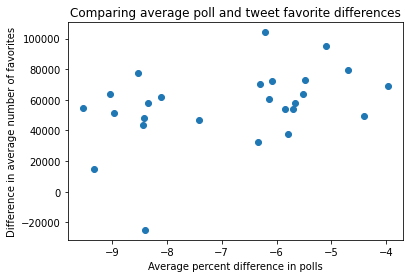

In [ ]:
# Check the scatterplot of percent poll difference and difference between average number of favorites for each candidate
plt.scatter(weekly_df['pct_difference'], weekly_df['favorite_avg'])
plt.title('Comparing average poll and tweet favorite differences')
plt.ylabel('Difference in average number of favorites')
plt.xlabel('Average percent difference in polls')
plt.show()

In [ ]:
# Calculate linear correlation coefficient
correl = scipy.stats.pearsonr(weekly_df['pct_difference'], weekly_df['favorite_avg'])
correl
# r = 0.39, barely at 0.05 significance

(0.39359609335809237, 0.04665940897197063)

In [ ]:
# r^2 of about 15%
correl[0]**2
# 15% of the candidates' poll average differences are accounted for by the differences in their tweet favorites

0.15491788470675216

# Bigrams and Trigrams

In [114]:
# Create a token list for each candidate for counting bigrams
trump_tokens = []
biden_tokens = []
# Remove custom punctuation and a couple of stopwords created from tokenization artifacts
# Note that most normal stopwords are NOT removed when looking at bigrams and trigrams
# However this made some results less interesting, so stopwords were added in
to_remove = set(stopwords.words('english')).union(['.', ',', '?', '!', ':', ';', '—', '-', '\'', '(', ')', '"', '”', '“', '’', '...', 't', 's', 'm'])
# Go through all the tweets and add to the token lists, filtering out these tokens
for name, tweet in zip(df['name'], df['text']):
  if name == 'Joe Biden':
    tokens = list(filter(lambda x: x not in to_remove, tt.tokenize(tweet.lower())))
    tokens.append('-') # End of tweet signal so bigrams don't put together adjacent tweets in the list
    biden_tokens.extend(tokens)
  else:
    tokens = list(filter(lambda x: x not in to_remove, tt.tokenize(tweet.lower())))
    tokens.append('-') # End of tweet signal so bigrams don't put together adjacent tweets in the list
    trump_tokens.extend(tokens)

print(len(trump_tokens))
print(len(biden_tokens))

85709
57410


In [115]:
# Count bigrams
trump_bigrams = BigramCollocationFinder.from_words(trump_tokens)
biden_bigrams = BigramCollocationFinder.from_words(biden_tokens)

# Take the top bigrams sorted by count, and create lists for the combined strings and counts to make it easier to plot
# Also remove any bigrams and trigrams that include the start/end marker
trump_top_bigrams = list(filter(lambda x: '-' not in x[0], sorted(trump_bigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:50]))
trump_top_bigram_words = list(map(lambda x: ' '.join(x[0]), trump_top_bigrams))
trump_top_bigram_counts = list(map(lambda x: x[1], trump_top_bigrams))

biden_top_bigrams = list(filter(lambda x: '-' not in x[0], sorted(biden_bigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:50]))
biden_top_bigram_words = list(map(lambda x: ' '.join(x[0]), biden_top_bigrams))
biden_top_bigram_counts = list(map(lambda x: x[1], biden_top_bigrams))

# Do the same for trigrams
trump_trigrams = TrigramCollocationFinder.from_words(trump_tokens)
biden_trigrams = TrigramCollocationFinder.from_words(biden_tokens)

trump_top_trigrams =  list(filter(lambda x: '-' not in x[0], sorted(trump_trigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:50]))
trump_top_trigram_words = list(map(lambda x: ' '.join(x[0]), trump_top_trigrams))
trump_top_trigram_counts = list(map(lambda x: x[1], trump_top_trigrams))

biden_top_trigrams =  list(filter(lambda x: '-' not in x[0], sorted(biden_trigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:50]))
biden_top_trigram_words = list(map(lambda x: ' '.join(x[0]), biden_top_trigrams))
biden_top_trigram_counts = list(map(lambda x: x[1], biden_top_trigrams))

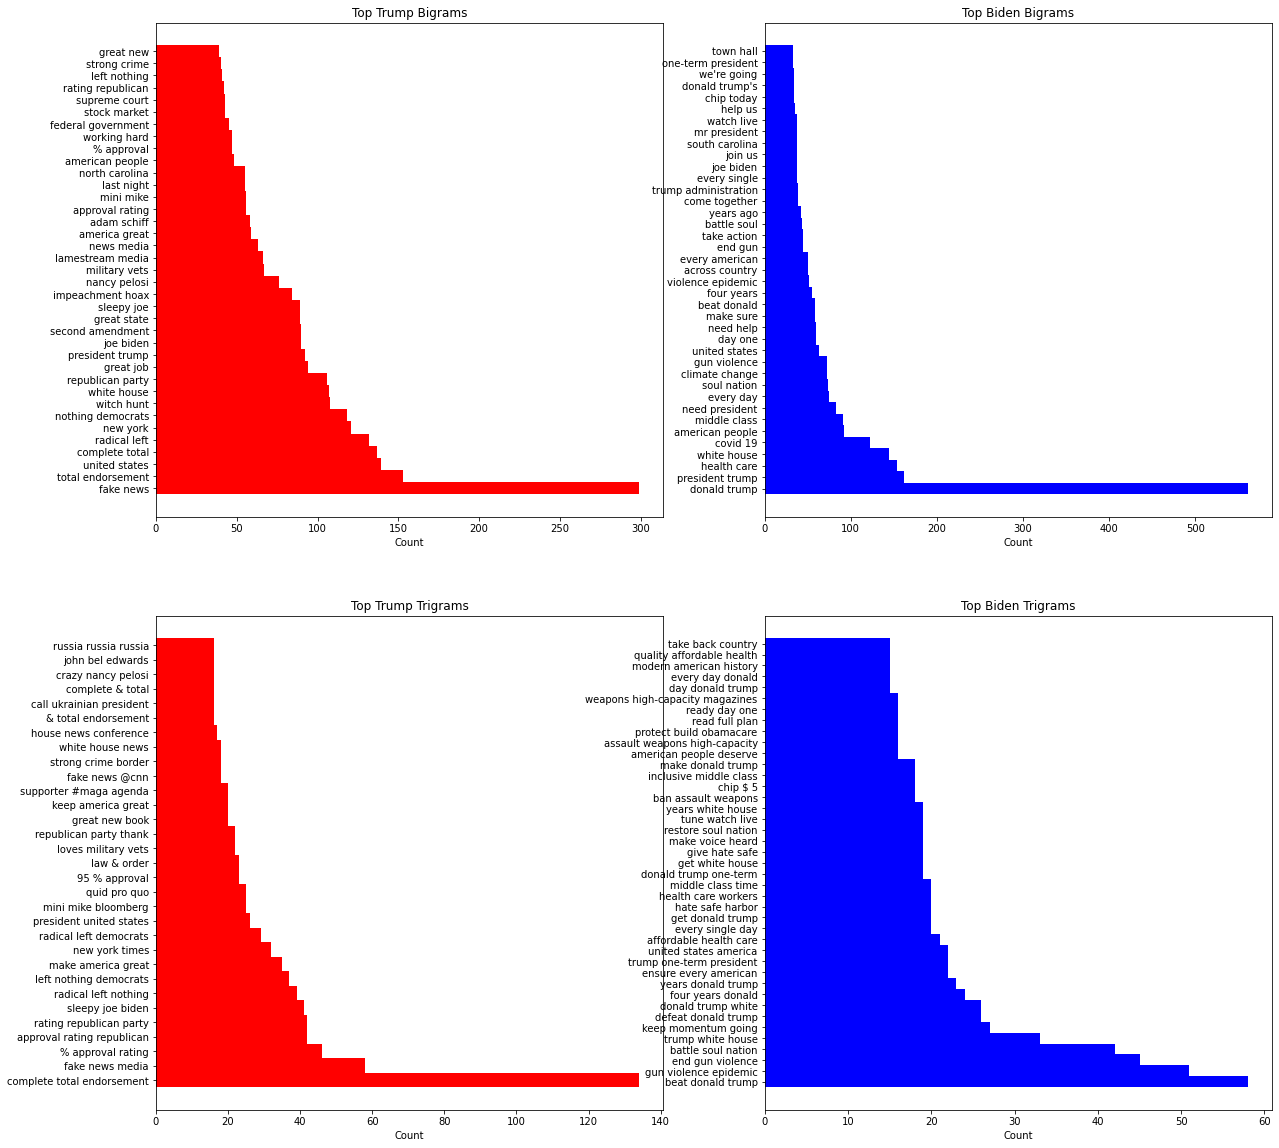

In [116]:
# Create 2x2 plot of top bigrams and trigrams
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[20,20])
axs[0,0].barh(trump_top_bigram_words, trump_top_bigram_counts, height=1, color='red')
axs[0,0].set_title('Top Trump Bigrams')
axs[0,0].set_xlabel('Count')
axs[0,1].barh(biden_top_bigram_words, biden_top_bigram_counts, height=1, color='blue')
axs[0,1].set_title('Top Biden Bigrams')
axs[0,1].set_xlabel('Count')
axs[1,0].barh(trump_top_trigram_words, trump_top_trigram_counts, height=1, color='red')
axs[1,0].set_title('Top Trump Trigrams')
axs[1,0].set_xlabel('Count')
axs[1,1].barh(biden_top_trigram_words, biden_top_trigram_counts, height=1, color='blue')
axs[1,1].set_title('Top Biden Trigrams')
axs[1,1].set_xlabel('Count')
plt.show()

# Bigram Graphs

In [117]:
# All bigrams, sorted
trump_sorted_bigrams = sorted(trump_bigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
biden_sorted_bigrams = sorted(biden_bigrams.ngram_fd.items(), key=lambda t: (-t[1], t[0]))

In [263]:
# Number of nodes to draw (most common words)
node_count = 25
trump_unigrams = FreqDist(list(filter(lambda x: x not in to_remove, trump_tokens)))
trump_nodes = trump_unigrams.most_common(node_count)
biden_unigrams = FreqDist(list(filter(lambda x: x not in to_remove, biden_tokens)))
biden_nodes = biden_unigrams.most_common(node_count)

trump_ref = list(map(lambda x: x[0], trump_nodes))
biden_ref = list(map(lambda x: x[0], biden_nodes))

In [264]:
# Add nodes to the graphs
trump_g = nx.DiGraph()
for node, freq in sorted(trump_nodes):
  trump_g.add_node(node, size=freq)

biden_g = nx.DiGraph()
for node, freq in sorted(biden_nodes):
  biden_g.add_node(node, size=freq)

In [265]:
# If I wanted this to be really fast, I'd make the references sorted lists and use binary search to get O(log n) checking. 
# Is it necessary? Not for a small number of nodes
# Add edges to the graphs
threshold = 5
for bigram in trump_sorted_bigrams:
  if bigram[0][0] in trump_ref and bigram[0][1] in trump_ref and bigram[1] > threshold:
    trump_g.add_edge(bigram[0][0], bigram[0][1], weight=bigram[1])

for bigram in biden_sorted_bigrams:
  if bigram[0][0] in biden_ref and bigram[0][1] in biden_ref and bigram[1] > threshold:
    biden_g.add_edge(bigram[0][0], bigram[0][1], weight=bigram[1])

In [279]:
# Weight function (square root looks a bit better than logarithmic, linear is a disaster)
trump_weights = [trump_g[u][v]['weight']**0.5 for u,v in trump_g.edges()]
biden_weights = [biden_g[u][v]['weight']**0.5 for u,v in biden_g.edges()]

#trump_weights = [2*np.log(trump_g[u][v]['weight']) for u,v in trump_g.edges()]
#biden_weights = [2*np.log(biden_g[u][v]['weight']) for u,v in biden_g.edges()]

trump_sizes = [u[1]['size'] for u in trump_g.nodes(data=True)]
biden_sizes = [u[1]['size'] for u in biden_g.nodes(data=True)]

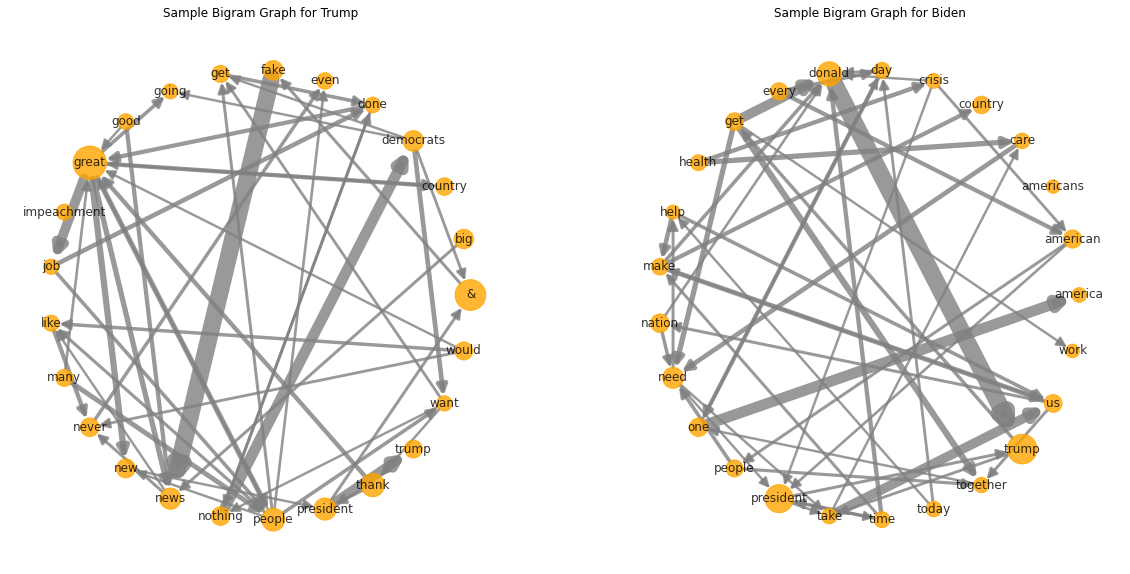

In [282]:
# Plot graphs
plt.figure(figsize=(20,10))
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
plt.subplot(121)
pos = nx.circular_layout(trump_g)
nx.draw(trump_g, pos, node_size=trump_sizes, with_labels=True, width=trump_weights, node_color='orange', edge_color='gray', arrowsize=20, alpha=0.8)
plt.title('Sample Bigram Graph for Trump')
plt.subplot(122)
pos = nx.circular_layout(biden_g)
nx.draw(biden_g, pos, node_size=biden_sizes, with_labels=True, width=trump_weights, node_color='orange', edge_color='gray', arrowsize=20, alpha=0.8)
plt.title('Sample Bigram Graph for Biden')
plt.show()